# Sessa Empirical Estimator (SEE) in Python with Enhanced Visualizations

This notebook implements the Sessa Empirical Estimator (SEE) method, originally developed in R, using Python. We simulate a sample dataset of medication events (with the same format as `med.events.ATC`) and then:

1. Compute time intervals between consecutive medication events per patient.
2. Compute the empirical cumulative distribution function (ECDF) and retain the lower 80% of values.
3. Transform the data (log-scale and standardize) and perform clustering using:
   - **K-Means** (with silhouette analysis to choose the number of clusters) and
   - **Agglomerative Clustering** as an alternative.
4. Visualize the results using a variety of charts:
   - Line chart (ECDF)
   - Histogram
   - Box plot
   - Pie chart & Bar chart (cluster distributions)
   - Scatter plot & Bubble chart
   - Waterfall chart (cumulative event intervals for a sample patient)
   - Heatmap (correlation matrix)
   



In [19]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Set visual style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# For reproducibility
np.random.seed(42)


## Sample Dataset

We simulate a dummy dataset with 7 variables:
- **PATIENT_ID:** Unique patient identifier.
- **DATE:** Medication event date.
- **DURATION:** Duration in days.
- **PERDAY:** Daily dosage.
- **CATEGORY:** ATC code (e.g., "medA").
- **CATEGORY_L1:** First field of the ATC code.
- **CATEGORY_L2:** First and second fields of the ATC code.

For demonstration purposes, we generate events for 16 patients.


In [20]:
# Simulate a sample dataset following the med.events.ATC format
n_patients = 16
rows = []

for pid in range(1, n_patients + 1):
    # Simulate between 80 to 100 events per patient.
    n_events = np.random.randint(80, 101)
    start_date = datetime.datetime(2020, 1, 1) + datetime.timedelta(days=np.random.randint(0, 30))
    for i in range(n_events):
        # Space events by a random multiple of days (between 1 and 30 days)
        date = start_date + datetime.timedelta(days=np.random.randint(1, 30) * i)
        duration = np.random.randint(1, 10)   # duration in days
        perday = np.round(np.random.uniform(0.5, 2.0), 2)  # daily dosage
        category = "medA"  # assume a single ATC code for demonstration
        category_l1 = "A"
        category_l2 = "A01"
        rows.append([pid, date, duration, perday, category, category_l1, category_l2])

df = pd.DataFrame(rows, columns=["PATIENT_ID", "DATE", "DURATION", "PERDAY", "CATEGORY", "CATEGORY_L1", "CATEGORY_L2"])
df["DATE"] = pd.to_datetime(df["DATE"])
print("Sample dataset shape:", df.shape)
df.head()


Sample dataset shape: (1411, 7)


,PATIENT_ID,DATE,DURATION,PERDAY,CATEGORY,CATEGORY_L1,CATEGORY_L2
0,1,2020-01-20,8,1.40,medA,A,A01
1,1,2020-01-27,3,0.65,medA,A,A01
2,1,2020-02-11,8,1.00,medA,A,A01
3,1,2020-02-13,8,1.48,medA,A,A01
4,1,2020-04-13,2,1.58,medA,A,A01


## Compute Event Intervals per Patient

We sort the data by patient and date, then compute the interval (in days) between each event and its previous event for every patient.


In [22]:
# Sort dataset by patient and DATE
df_sorted = df.sort_values(by=["PATIENT_ID", "DATE"]).reset_index(drop=True)

# Compute the previous DATE for each patient and calculate the event interval (in days)
df_sorted["prev_DATE"] = df_sorted.groupby("PATIENT_ID")["DATE"].shift(1)
df_sorted["event_interval"] = (df_sorted["DATE"] - df_sorted["prev_DATE"]).dt.days

# Remove rows with NaN interval (first event per patient)
df_intervals = df_sorted.dropna(subset=["event_interval"]).copy()
df_intervals.head()


,PATIENT_ID,DATE,DURATION,PERDAY,CATEGORY,CATEGORY_L1,CATEGORY_L2,prev_DATE,event_interval
1,1,2020-01-27,3,0.65,medA,A,A01,2020-01-20,7.0
2,1,2020-02-11,8,1.00,medA,A,A01,2020-01-27,15.0
3,1,2020-02-13,8,1.48,medA,A,A01,2020-02-11,2.0
4,1,2020-02-19,2,0.77,medA,A,A01,2020-02-13,6.0
5,1,2020-02-23,6,0.81,medA,A,A01,2020-02-19,4.0


## Sample One Event per Patient

Following the original SEE method, we randomly sample one event (and its computed interval) per patient.


In [23]:
# Sample one row per patient randomly
df_sample = df_intervals.groupby("PATIENT_ID").apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True)
df_sample = df_sample[["PATIENT_ID", "event_interval"]]
df_sample.head()


C:\Users\justi\AppData\Local\Temp\ipykernel_19920\4006576125.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df_intervals.groupby("PATIENT_ID").apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True)


,PATIENT_ID,event_interval
0,1,9.0
1,2,5.0
2,3,50.0
3,4,58.0
4,5,9.0


## Compute the Empirical Cumulative Distribution Function (ECDF)

We compute the ECDF of the event intervals and retain the lower 80% of values.


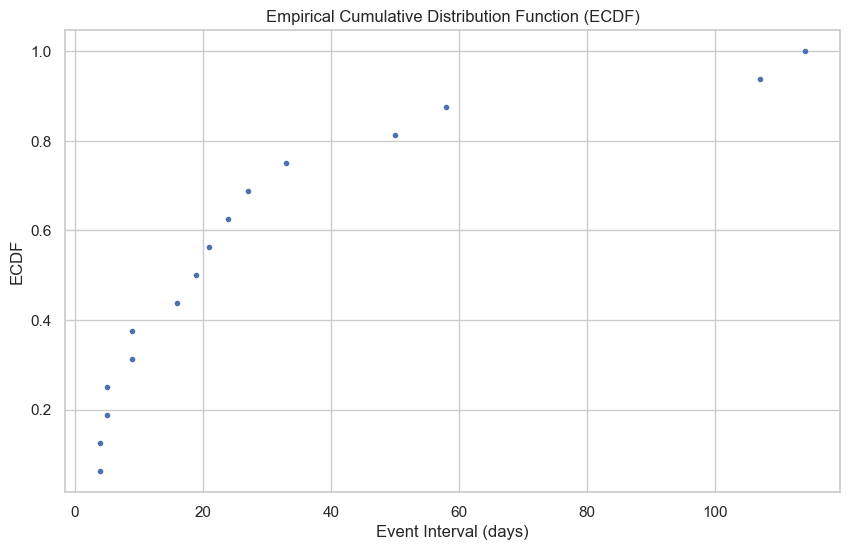


80% ECDF threshold (max event_interval): 33.0


Filtered sample shape: (12, 2)



In [41]:
# Compute ECDF for event_interval
x = np.sort(df_sample["event_interval"].values)
n = len(x)
ecdf = np.arange(1, n+1) / n

# Plot ECDF as a line chart
plt.figure()
plt.plot(x, ecdf, marker=".", linestyle="none")
plt.title("Empirical Cumulative Distribution Function (ECDF)")
plt.xlabel("Event Interval (days)")
plt.ylabel("ECDF")
plt.grid(True)
plt.show()

# Retain the lower 80% of the ECDF
x_80 = x[ecdf <= 0.8]
threshold = np.max(x_80)

# Enlarged print statement
print("\n" + "="*50)
print(f"80% ECDF threshold (max event_interval): {threshold}")
print("="*50 + "\n")

# Filter the sample data using the threshold
df_filtered = df_sample[df_sample["event_interval"] <= threshold].copy()

# Enlarged print statement
print("\n" + "="*50)
print(f"Filtered sample shape: {df_filtered.shape}")
print("="*50 + "\n")


## Data Transformation for Clustering

We take the natural logarithm of the event intervals and standardize the data.


In [25]:
# Log-transform the event_interval
df_filtered["log_event_interval"] = np.log(df_filtered["event_interval"])

# Standardize the log-transformed data
scaler = StandardScaler()
X = scaler.fit_transform(df_filtered[["log_event_interval"]])


## Clustering with K-Means

We perform K-Means clustering on the transformed data. First, we run silhouette analysis over a range of cluster numbers to select the best number of clusters.


In [44]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Determine the optimal number of clusters using silhouette scores
range_n_clusters = range(2, 7)
best_score = -1
best_n_clusters = 2

print("\n" + "="*60)
print("Silhouette Scores for Different Cluster Numbers")
print("="*60)

for n_clusters in range_n_clusters:
    kmeans_temp = KMeans(n_clusters=n_clusters, random_state=42)
    labels_temp = kmeans_temp.fit_predict(X)
    score = silhouette_score(X, labels_temp)
    print(f"  - {n_clusters} clusters: Silhouette Score = {score:.3f}")
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters

print("\n" + "="*60)
print(f"Optimal number of clusters (K-Means): {best_n_clusters}")
print("="*60 + "\n")

# Apply K-Means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
df_filtered["cluster_kmeans"] = kmeans.fit_predict(X)

# Display median event_interval per K-Means cluster
kmeans_summary = df_filtered.groupby("cluster_kmeans")["event_interval"].median().reset_index()

print("\n" + "="*60)
print("K-Means Cluster Medians (Event Interval)")
print("="*60)
print(kmeans_summary.to_string(index=False))
print("="*60 + "\n")



Silhouette Scores for Different Cluster Numbers
  - 2 clusters: Silhouette Score = 0.705
  - 3 clusters: Silhouette Score = 0.740
  - 4 clusters: Silhouette Score = 0.665
  - 5 clusters: Silhouette Score = 0.737
  - 6 clusters: Silhouette Score = 0.654

Optimal number of clusters (K-Means): 3


K-Means Cluster Medians (Event Interval)
 cluster_kmeans  event_interval
              0             4.5
              1            22.5
              2             9.0



## Clustering with Agglomerative Clustering

We perform Agglomerative Clustering as an alternative method.


In [45]:
from sklearn.cluster import AgglomerativeClustering

# Apply Agglomerative Clustering with the same optimal number of clusters
agg = AgglomerativeClustering(n_clusters=best_n_clusters)
df_filtered["cluster_agg"] = agg.fit_predict(X)

# Display median event_interval per Agglomerative cluster
agg_summary = df_filtered.groupby("cluster_agg")["event_interval"].median().reset_index()

print("\n" + "="*60)
print("Agglomerative Clustering Cluster Medians (Event Interval)")
print("="*60)
print(agg_summary.to_string(index=False))
print("="*60 + "\n")



Agglomerative Clustering Cluster Medians (Event Interval)
 cluster_agg  event_interval
           0            22.5
           1             4.5
           2             9.0



## Visualizations

Below we include several visualizations to better understand the data and clustering results.


### 1. Histogram of Event Intervals

This histogram shows the distribution of event intervals (in days).


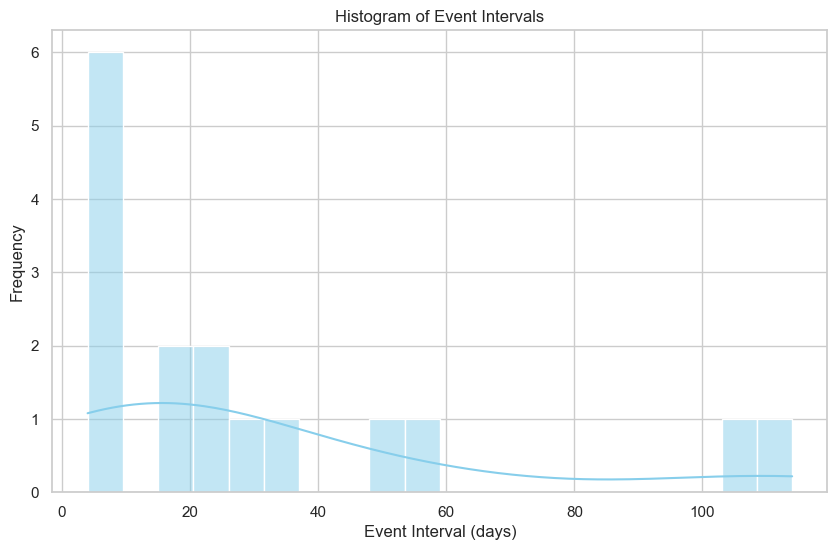

In [31]:
plt.figure()
sns.histplot(df_sample["event_interval"], bins=20, kde=True, color="skyblue")
plt.title("Histogram of Event Intervals")
plt.xlabel("Event Interval (days)")
plt.ylabel("Frequency")
plt.show()


### 2. Box Plots of Event Intervals by Cluster

We compare the distribution of event intervals across clusters from both clustering methods.


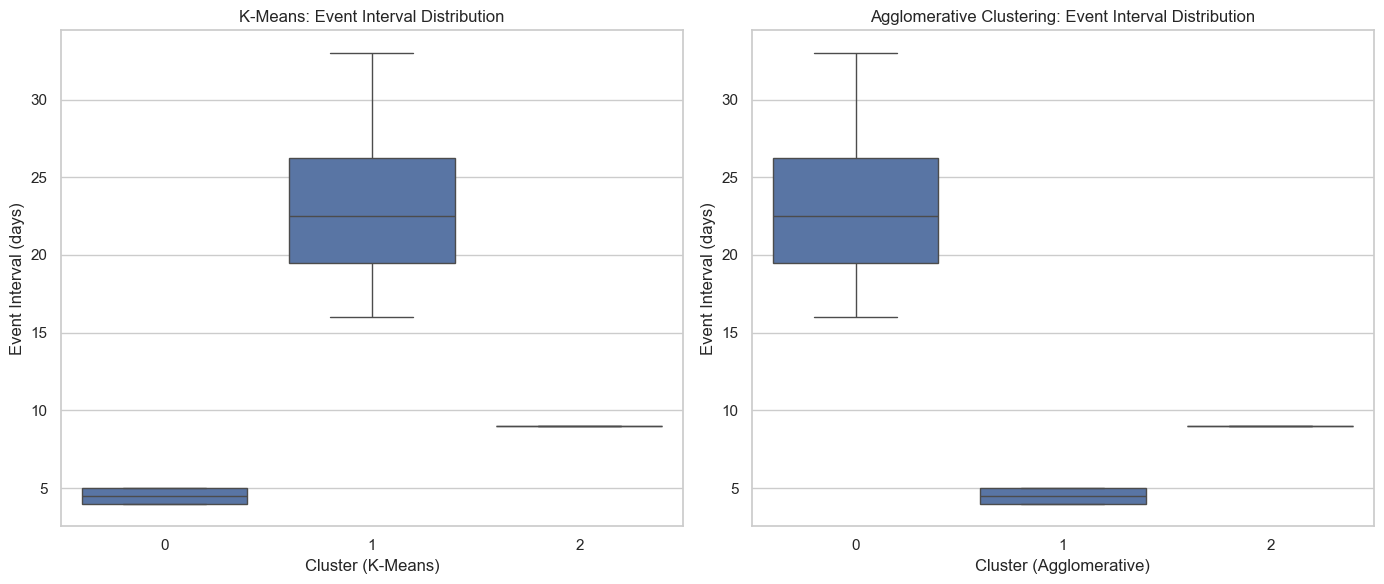

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(x="cluster_kmeans", y="event_interval", data=df_filtered, ax=ax[0])
ax[0].set_title("K-Means: Event Interval Distribution")
ax[0].set_xlabel("Cluster (K-Means)")
ax[0].set_ylabel("Event Interval (days)")

sns.boxplot(x="cluster_agg", y="event_interval", data=df_filtered, ax=ax[1])
ax[1].set_title("Agglomerative Clustering: Event Interval Distribution")
ax[1].set_xlabel("Cluster (Agglomerative)")
ax[1].set_ylabel("Event Interval (days)")

plt.tight_layout()
plt.show()


### 3. Scatter Plot and Bubble Chart: Event Interval vs. Log(Event Interval)

We create a scatter plot where points are colored by K-Means cluster. In the bubble chart version, the point size represents a dummy frequency value.


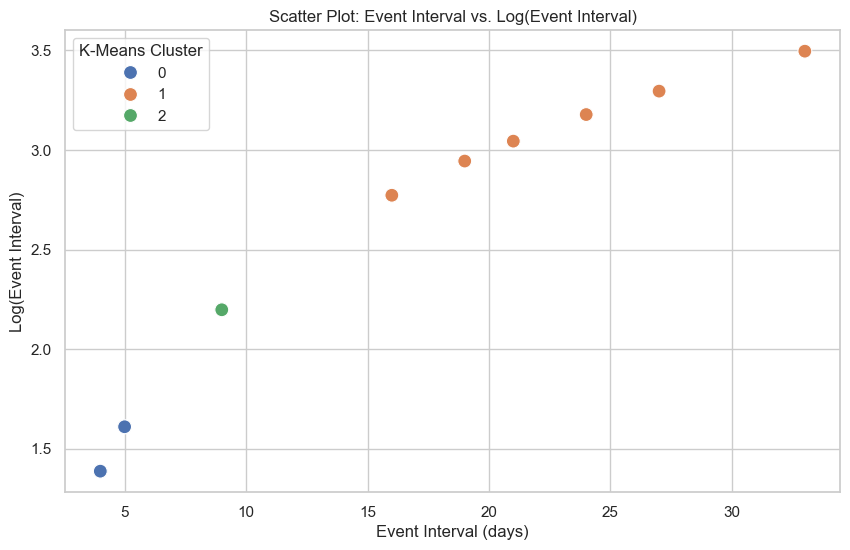

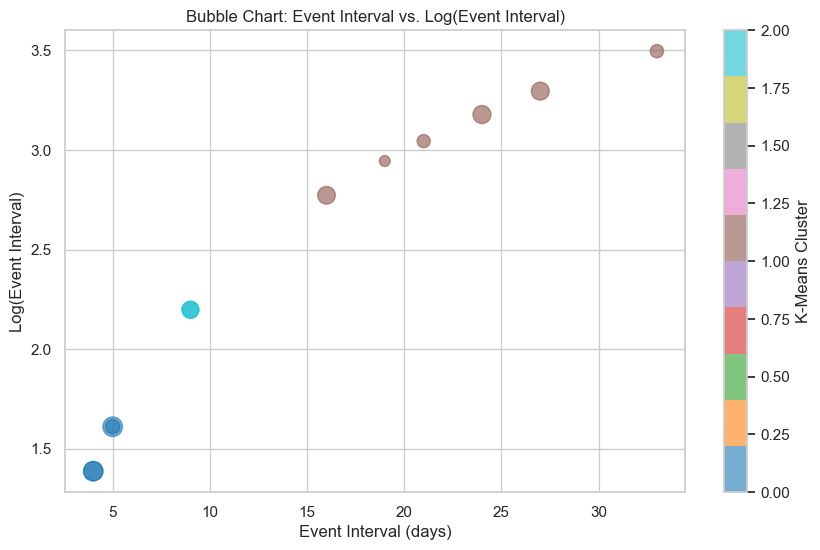

In [37]:
# Scatter plot with cluster colors
plt.figure()
sns.scatterplot(x="event_interval", y="log_event_interval", hue="cluster_kmeans", data=df_filtered, palette="deep", s=100)
plt.title("Scatter Plot: Event Interval vs. Log(Event Interval)")
plt.xlabel("Event Interval (days)")
plt.ylabel("Log(Event Interval)")
plt.legend(title="K-Means Cluster")
plt.show()

# For bubble chart, assign a dummy 'frequency' value (here using random values for demonstration)
df_filtered["frequency"] = np.random.randint(50, 200, size=df_filtered.shape[0])
plt.figure()
plt.scatter(df_filtered["event_interval"], df_filtered["log_event_interval"],
            s=df_filtered["frequency"], c=df_filtered["cluster_kmeans"], cmap="tab10", alpha=0.6)
plt.title("Bubble Chart: Event Interval vs. Log(Event Interval)")
plt.xlabel("Event Interval (days)")
plt.ylabel("Log(Event Interval)")
plt.colorbar(label="K-Means Cluster")
plt.show()


### 4. Waterfall Chart: Cumulative Event Intervals for a Sample Patient

We select one patient and create a waterfall chart to show the cumulative sum of event intervals.


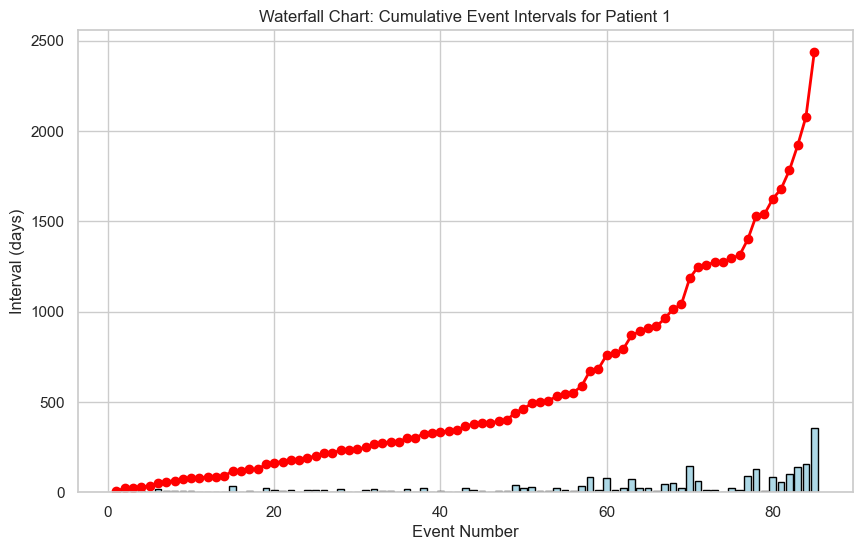

In [39]:
# Select one sample patient (e.g., patient 1) and sort their events by DATE
patient_id = 1
df_patient = df_intervals[df_intervals["PATIENT_ID"] == patient_id].sort_values("DATE").copy()
df_patient["cumulative_interval"] = df_patient["event_interval"].cumsum()

# Create waterfall-like chart
plt.figure()
plt.bar(df_patient.index, df_patient["event_interval"], color="lightblue", edgecolor="black")
plt.plot(df_patient.index, df_patient["cumulative_interval"], marker="o", color="red", linewidth=2)
plt.title(f"Waterfall Chart: Cumulative Event Intervals for Patient {patient_id}")
plt.xlabel("Event Number")
plt.ylabel("Interval (days)")
plt.show()
